In [1]:
#Importin Libraries
import re
import wget
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Downloading Dataset
name = 'housingdata.csv'
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv' 

#wget.download(url, name)

In [3]:
#Loading Dataset

cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]

data = pd.read_csv('housingdata.csv' ,usecols=cols)
data.total_bedrooms = data.total_bedrooms.fillna(0) #filling missing values

Data Transformation

Spliting Data using random_state of 1

In [4]:
data.median_house_value = np.log1p(data.median_house_value)   #applying log tansformation

#spliting data
full_train_df, full_test_df = train_test_split(data, test_size = 0.2, random_state=1) 
full_train_df, full_val_df = train_test_split(full_train_df, test_size = 0.25, random_state=1)

train_df = full_train_df.reset_index(drop = True)
test_df = full_test_df.reset_index(drop = True)
val_df = full_val_df.reset_index(drop = True)

#choosing target column
y_train = train_df['median_house_value']
y_test = test_df['median_house_value']
y_val = val_df['median_house_value']

del train_df['median_house_value']
del test_df['median_house_value']
del val_df['median_house_value']

Using DictVectorizer to turn train and validation into matrices.

In [5]:
dv = DictVectorizer(sparse = False) #calling dict vectorizer

dv.fit(train_df.to_dict(orient = 'records')) #fitting dictvectoriser on training data
feature_names = dv.get_feature_names()

#transforming data with dictvectoriser
X_train = dv.transform(train_df.to_dict(orient = 'records'))
X_test = dv.transform(test_df.to_dict(orient = 'records'))
X_val = dv.transform(val_df.to_dict(orient = 'records'))

Question 1: Which feature is used for splitting the data?

In [6]:
#training decision tree regressor to predict the median_house_value variable using max_depth=1.
model = DecisionTreeRegressor(max_depth=1) 
model.fit(X_train, y_train)  #fitting model on data

DecisionTreeRegressor(max_depth=1)

Inspection of model

In [7]:
inspect = export_text(model, feature_names = feature_names) #Checking feature for spliting data
print(inspect)

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



Answer: ocean_proximity=INLAND


Question 2: What's the RMSE of this model on validation?

In [8]:
# training Random Forest using
# n_estimators=10
# random_state=1
# n_jobs=-1 

model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1) 
model.fit(X_train, y_train)

prediction = model.predict(X_val)
error = mean_squared_error(y_val, prediction)
error = np.sqrt(error)
print(round(error,2))

0.25


Answer: 0.25

Question 3: After which value of n_estimators does RMSE stop improving?

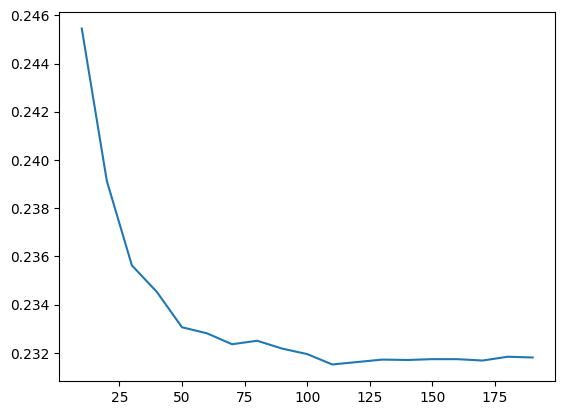

In [9]:
#Training random forest with different number of estimators
scores = []

for i in range(10,200,10):
    model = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=-1)
    model.fit(X_train, y_train)

    prediction = model.predict(X_val)
    error = mean_squared_error(y_val, prediction)
    error = np.sqrt(error)
    scores.append([i,error])

output = pd.DataFrame(scores, columns = ['n_estimators', 'error'])

#Inspecting the model performances
plt.plot(output.n_estimators, output.error)

(0.2, 0.24)

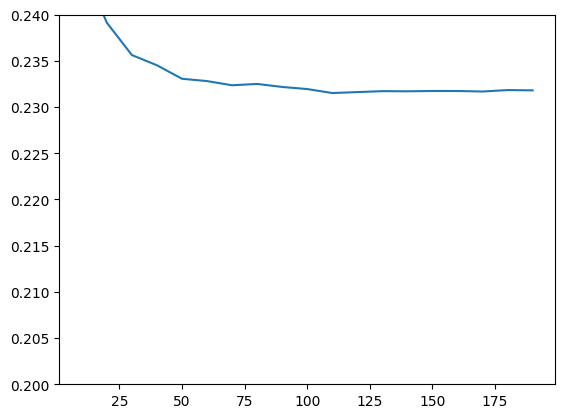

In [10]:
#Zooming into the plot
plt.plot(output.n_estimators, output.error)
plt.ylim(0.2, 0.24)

Answer: 50

Question 4: What's the best max_depth?

In [11]:
#Training random forest with differt depths for each number of estimators
max_depth = [10, 15, 20, 25]
scores = []
for d in max_depth:
    for i in range(10,200,10):
        model = RandomForestRegressor(n_estimators=i, max_depth = d, random_state=1, n_jobs=-1)
        model.fit(X_train, y_train)

        prediction = model.predict(X_val)
        error = mean_squared_error(y_val, prediction)
        error = np.sqrt(error)
        scores.append([d, i,error])

output = pd.DataFrame(scores, columns = ['depth', 'n_estimators', 'error'])

In [12]:
output = output.sort_values('error')
output = output.reset_index(drop = True)
min_err = output['error'].min() #checking the min error in the table
best_depth = output[output['error'] == min_err]['depth'] #Checking the best depth
print(best_depth)

0    25
Name: depth, dtype: int64


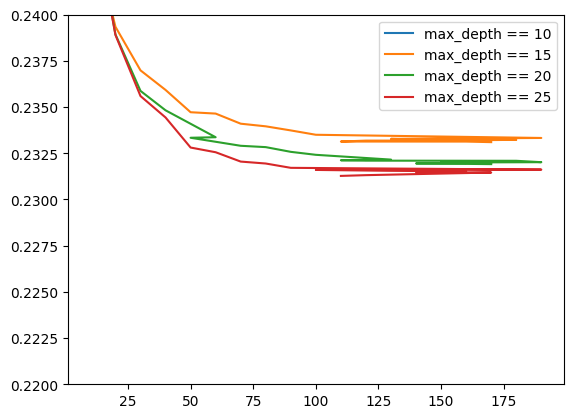

In [13]:
#Visualization

for i in max_depth:
    data = output[output.depth == i]
    plt.plot(data.n_estimators, data.error, label = 'max_depth == %s'%(i))
plt.ylim(0.22, 0.24) #zooming in
plt.legend()

Answer: 25

Question 5: What's the most important feature?

In [14]:
# Training RandomForest using
# n_estimators=10
# max_depth=20
# random_state=1
# n_jobs=-1 

model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)

#Getting Feature importance
importance = model.feature_importances_

feature_importances = pd.Series(importance, index=feature_names)
max = feature_importances[feature_importances == feature_importances.max()].index.tolist() #feature with the maximum feature importance
print(max)

['median_income']


Answer: 'median_income'

Question 6: Which eta leads to the best RMSE score on the validation dataset?

In [15]:
#Creating Dmatrix
regex = re.compile(r"\[|\]|<", re.IGNORECASE)  #using re library to revome signs from the feature names
feature_names  = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in feature_names]


dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = feature_names)
dtest = xgb.DMatrix(X_test, label = y_test, feature_names = feature_names)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = feature_names)

#Creating watchlist
watch_list = [(dtrain,'train'), (dval,'validation')]

In [16]:
def parse_xgboost():

    '''Function for parsing output of xgboost'''

    itrs = []
    training_error = []
    validation_error = []

    for i in table.stdout.strip().split('\n'):
        itr, train_error, test_error = i.split('\t')
        itr = int(itr.strip('[]'))
        train_error = float(train_error.split(':')[1])
        test_error = float(test_error.split(':')[1])

        itrs.append(itr)
        training_error.append(train_error)
        validation_error.append(test_error)

    dicts = {'itr': itrs, 'training_error':training_error, 'validation_error':validation_error}
    output = pd.DataFrame(dicts)
    return output

In [17]:
scores = {} #Dictionary to take different eta value as keys and the it dataframe as value

In [19]:
%%capture table

#xgboost parameters
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

#Training xgboost
model = xgb.train(xgb_params, dtrain = dtrain, evals = watch_list, num_boost_round=100)

In [20]:
key = 'eta = %s' %(xgb_params['eta'])
scores[key] = parse_xgboost()

In [22]:
%%capture table

#xgboost parameters
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

#Training xgboost
model = xgb.train(xgb_params, dtrain = dtrain, evals = watch_list, num_boost_round=100)

In [23]:
key = 'eta = %s' %(xgb_params['eta'])
scores[key] = parse_xgboost()

In [24]:
scores.keys()

dict_keys(['eta = 0.3', 'eta = 0.1'])

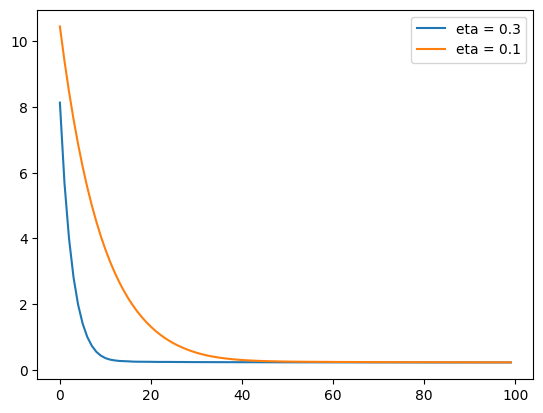

In [25]:
for key, value in scores.items():
    plt.plot(value.itr, value.validation_error, label = key)

plt.legend()

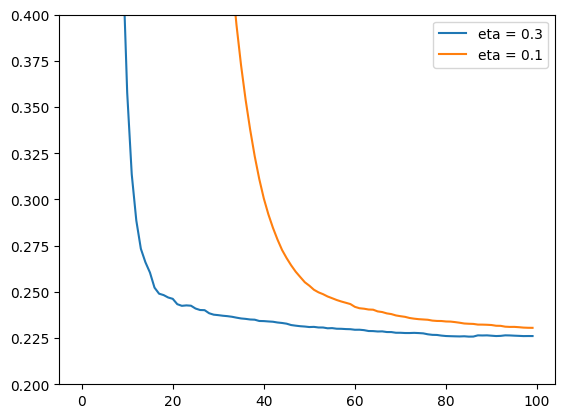

In [26]:
#Zooming into the plot
for key, value in scores.items():
    plt.plot(value.itr, value.validation_error, label = key)

plt.ylim(0.2, 0.4)
plt.legend()

Answer: 0.3